This tutorial shows how to preprocess the raw data files from 10x database and feed into attention-base feed forward network for categorical classification. The introduction of 10x can be found here: https://www.10xgenomics.com

In [1]:
import pandas as pd
import tcellmatch.api as tm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_model_summary import summary
from torchmetrics import Accuracy
import torch
import os
import numpy as np
#!! TODO -> remove tensorflow from venv

2023-06-13 16:42:21.409483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Get Data Directories

In [2]:
# Path of input directory.
indir = ''
# Path to 10x raw files.
fns = ["vdj_v1_hs_aggregated_donor1_binarized_matrix.csv",
       "vdj_v1_hs_aggregated_donor2_binarized_matrix.csv"]
# Path to preprocessed clonotypes files.
fns_clonotype = ["vdj_v1_hs_aggregated_donor1_clonotypes.csv",
                 "vdj_v1_hs_aggregated_donor2_clonotypes.csv"]
# Path to preprocessed covariates files.
# covariates: pd.DataFrame with covariates including TCR CDR3 sequence by cell and chain [observations, covariates]
fns_covar = ["vdj_v1_hs_aggregated_donor1_binarized_matrix_extended_covariates.csv",
             "vdj_v1_hs_aggregated_donor2_binarized_matrix_extended_covariates.csv"]

In [3]:
cellranger_out = pd.read_csv(fns[0])
cellranger_out.head()

,barcode,donor,cell_clono_cdr3_aa,cell_clono_cdr3_nt,CD3,CD19,CD45RA,CD4,CD8a,CD14,...,B0702_RPHERNGFTVL_pp65_CMV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,B0801_ELRRKMMYM_IE-1_CMV_binder,B0801_FLRGRAYGL_EBNA-3A_EBV_binder,A0101_SLEGGGLGY_NC_binder,A0101_STEGGGLAY_NC_binder,A0201_ALIAPVHAV_NC_binder,A2402_AYSSAGASI_NC_binder,B0702_GPAESAAGL_NC_binder,NR(B0801)_AAKGRGAAL_NC_binder
0,AAACCTGAGACAAAGG-4,donor1,TRA:CAASVSIWTGTASKLTF;TRA:CAAWDMEYGNKLVF;TRB:C...,TRA:TGTGCAGCAAGCGTTAGTATTTGGACCGGCACTGCCAGTAAA...,2125.0,0.0,912.0,1.0,2223.0,4.0,...,False,False,False,False,False,False,False,False,False,False
1,AAACCTGAGACTGTAA-34,donor1,TRB:CASDTPVGQFF,TRB:TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,1023.0,0.0,2028.0,2.0,3485.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,AAACCTGAGAGCCCAA-5,donor1,TRA:CASYTDKLIF;TRB:CASSGGSISTDTQYF,TRA:TGTGCTTCCTACACCGACAAGCTCATCTTT;TRB:TGCGCCA...,1598.0,3.0,3454.0,4.0,3383.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,AAACCTGAGAGCTGCA-24,donor1,TRB:CASSGGQSSYEQYF,TRB:TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,298.0,1.0,880.0,1.0,2389.0,1.0,...,False,False,False,False,False,False,False,False,False,False
4,AAACCTGAGAGGGATA-8,donor1,TRA:CAASGYGNTGRRALTF;TRB:CASSQDPAGGYNEQFF,TRA:TGTGCAGCAAGCGGGTATGGAAACACGGGCAGGAGAGCACTT...,1036.0,0.0,2457.0,2.0,3427.0,3.0,...,False,False,False,False,False,False,False,False,False,False


In [4]:
data = cellranger_out
column_names = data.columns
column_types = data.dtypes

In [5]:
cellranger_out = pd.read_csv(fns_clonotype[0])
cellranger_out.head()

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt
0,clonotype1,2407,0.050583,TRA:CAGHTGNQFYF;TRB:CASSWGGGSHYGYTF,TRA:TGTGCTGGTCACACCGGTAACCAGTTCTATTTT;TRB:TGTG...
1,clonotype2,1244,0.026143,TRA:CAARVRGFGNVLHC;TRA:CAVGDNFNKFYF;TRB:CASSLY...,TRA:TGTGCAGCAAGAGTGCGGGGCTTTGGGAATGTGCTGCATTGC...
2,clonotype3,1167,0.024525,TRB:CASSWGGGSHYGYTF,TRB:TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC
3,clonotype4,512,0.010760,TRA:CAVSAASGGSYIPTF;TRB:CASSPRDRERGEQYF,TRA:TGTGCTGTGAGTGCAGCATCAGGAGGAAGCTACATACCTACA...
4,clonotype5,419,0.008805,TRA:CAMNPAWGGATNKLIF;TRB:CSASPGDYEQYF,TRA:TGTGCAATGAACCCGGCGTGGGGTGGTGCTACAAACAAGCTC...


## List of column names of lables to predict in 10x raw files
Here we take all antigens from 10x dataset for prediction

In [6]:
target_ids = [
    'A0101_VTEHDTLLY_IE-1_CMV_binder',
    'A0201_KTWGQYWQV_gp100_Cancer_binder',
    'A0201_ELAGIGILTV_MART-1_Cancer_binder',
    'A0201_CLLWSFQTSA_Tyrosinase_Cancer_binder',
    'A0201_IMDQVPFSV_gp100_Cancer_binder',
    'A0201_SLLMWITQV_NY-ESO-1_Cancer_binder',
    'A0201_KVAELVHFL_MAGE-A3_Cancer_binder',
    'A0201_KVLEYVIKV_MAGE-A1_Cancer_binder',
    'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase_binder',
    'A0201_LLDFVRFMGV_EBNA-3B_EBV_binder',
    'A0201_LLMGTLGIVC_HPV-16E7_82-91_binder',
    'A0201_CLGGLLTMV_LMP-2A_EBV_binder',
    'A0201_YLLEMLWRL_LMP1_EBV_binder',
    'A0201_FLYALALLL_LMP2A_EBV_binder',
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0201_GLCTLVAML_BMLF1_EBV_binder',
    'A0201_NLVPMVATV_pp65_CMV_binder',
    'A0201_ILKEPVHGV_RT_HIV_binder',
    'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder',
    'A2402_CYTWNQMNL_WT1-(235-243)236M_Y_binder',
    'A0201_RTLNAWVKV_Gag-protein_HIV_binder',
    'A0201_KLQCVDLHV_PSA146-154_binder',
    'A0201_LLFGYPVYV_HTLV-1_binder',
    'A0201_SLFNTVATL_Gag-protein_HIV_binder',
    'A0201_SLYNTVATLY_Gag-protein_HIV_binder',
    'A0201_SLFNTVATLY_Gag-protein_HIV_binder',
    'A0201_RMFPNAPYL_WT-1_binder',
    'A0201_YLNDHLEPWI_BCL-X_Cancer_binder',
    'A0201_MLDLQPETT_16E7_HPV_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
    'A0301_RIAAWMATY_BCL-2L1_Cancer_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
    'B3501_IPSINVHHY_pp65_CMV_binder',
    'A2402_AYAQKIFKI_IE-1_CMV_binder',
    'A2402_QYDPVAALF_pp65_CMV_binder',
    'B0702_QPRAPIRPI_EBNA-6_EBV_binder',
    'B0702_TPRVTGGGAM_pp65_CMV_binder',
    'B0702_RPPIFIRRL_EBNA-3A_EBV_binder',
    'B0702_RPHERNGFTVL_pp65_CMV_binder',
    'B0801_RAKFKQLL_BZLF1_EBV_binder',
    'B0801_ELRRKMMYM_IE-1_CMV_binder',
    'B0801_FLRGRAYGL_EBNA-3A_EBV_binder',
    'A0101_SLEGGGLGY_NC_binder',
    'A0101_STEGGGLAY_NC_binder',
    'A0201_ALIAPVHAV_NC_binder',
    'A2402_AYSSAGASI_NC_binder',
    'B0702_GPAESAAGL_NC_binder',
    'NR(B0801)_AAKGRGAAL_NC_binder'
]

## List of column names of negative controls in 10x raw files

In [7]:
nc_cols = [
    'A0101_SLEGGGLGY_NC_binder',
    'A0101_STEGGGLAY_NC_binder',
    'A0201_ALIAPVHAV_NC_binder',
    'A2402_AYSSAGASI_NC_binder',
    'B0702_GPAESAAGL_NC_binder',
    'NR(B0801)_AAKGRGAAL_NC_binder'
]

# Read data

## Create model object
EstimatorFfn() includes all of reading, training and testing modules.

In [8]:
# init function doesn't use any tf, but...
ffn = tm.models.EstimatorFfn()

## Read 10x raw files, taking out TCR CDR3 and binarized binding matrix as training data
We encode the TCR CDR3 amino acid sequences (include TRA and TRB) with one-hot encoding, the embedded sequences are of shape [num_samples, tra/trb, max_sequence_length, aa_onehot_dim]. For example if we take out 4000 TRB sequences seperately, the maximal length of sequences is 30 and we have 22 amino acids, the shape of output would be [4000, 1, 30, 26]. 

In [9]:
# no tf
ffn.read_binarized_matrix(
    fns=[indir + x for x in fns],
    fns_clonotype=[indir + x for x in fns_clonotype],
    fns_covar=[],
    fn_blosum=None,
    blosum_encoding=False,
    is_train=True,
    covariate_formula_categ=["donor"],
    covariate_formula_numeric=[],
    add_non_binder_for_softmax=True,
    chains="trb",
    label_cols=target_ids,
    nc_cols=nc_cols
)

/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packag

Found 29618 clonotypes for 46526 observations in single file.


/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  covariates_table[x] = cell_table[x].values
/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packag

Found 19318 clonotypes for 77854 observations in single file.


/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_temp[new_id] = table_temp[x].values
/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages/tcellmatch/estimators/estimator_base.py:1366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table_temp[new_id] = table_temp[x].values
/Users/johnboesen/Documents/Code/#Work/tcellmatch/tcell-env/lib/python3.11/site-packages

Found 40500 clonotypes for 109637 observations and assigned to train data.


The input consists of TCR CDR3 sequences and covariates, covariates act as a additional information which will be concatenated with TCR CDR3 sequences during training. The target set would be a binarized matrix which shows the binding between TCR CDR3 and antigens.

In [10]:
print("Shape of TCR sequences: ",ffn.x_train.shape)
# print("The head of TCR sequences: ",ffn.x_train[0])
print("Shape of covariates: ",ffn.covariates_train.shape)
# print("The head of covariates: ",ffn.covariates_train[0:5])
print("Shape of target set: ",ffn.y_train.shape)
# print("The head of target set: ",ffn.y_train[0:5])

Shape of TCR sequences:  (109637, 1, 27, 26)
Shape of covariates:  (109637, 2)
Shape of target set:  (109637, 51)


## Downsample clonotypes
This avoids training, evaluation or test set to be too biased to a subset of TCRs.

In [11]:
# max_obs: Maximum number of observations per clonotype.
ffn.downsample_clonotype(max_obs=10)

Downsampled 40500 clonotypes from 109637 cells to 56887 cells.


In [12]:
print("Shape of TCR sequences: ",ffn.x_train.shape)
print("Shape of covariates: ",ffn.covariates_train.shape)
print("Shape of target set: ",ffn.y_train.shape)

Shape of TCR sequences:  (56887, 1, 27, 26)
Shape of covariates:  (56887, 2)
Shape of target set:  (56887, 51)


## Create test dataset
We can either split a part of training set or use a new database as the test set. Here we split test set from training set.

In [13]:
ffn.clear_test_data()
ffn.sample_test_set(test_split=0.1)

Number of observations in test data: 5624
Number of observations in training+evaluation data: 51263


In [14]:
print("Shape of TCR CDR3 sequences for training: ",ffn.x_train.shape)
print("Shape of covariates for training: ",ffn.covariates_train.shape)
print("Shape of target set for training: ",ffn.y_train.shape)
print("Shape of TCR CDR3 sequences for test: ",ffn.x_test.shape)
print("Shape of covariates for test: ",ffn.covariates_test.shape)
print("Shape of target set for test: ",ffn.y_test.shape)

Shape of TCR CDR3 sequences for training:  (51263, 1, 27, 26)
Shape of covariates for training:  (51263, 2)
Shape of target set for training:  (51263, 51)
Shape of TCR CDR3 sequences for test:  (5624, 1, 27, 26)
Shape of covariates for test:  (5624, 2)
Shape of target set for test:  (5624, 51)


## Padding TCR CDR3 sequences in both training and testing set
Since we can use TCR CDR3 in another database as test set, we should make sure they have same size.

In [15]:
# no tf
ffn.pad_sequence(target_len=40, sequence="tcr")

In [16]:
print("Shape of TCR CDR3 sequences for training: ",ffn.x_train.shape)
print("Shape of TCR CDR3 sequences for test: ",ffn.x_test.shape)

Shape of TCR CDR3 sequences for training:  (51263, 1, 40, 26)
Shape of TCR CDR3 sequences for test:  (5624, 1, 40, 26)


## Downsample data to given number of observations.
In order to save time we sample a small dataset for training. Never use this method in practice. 

In [17]:
print("Shape of TCR CDR3 sequences for training: ",ffn.x_train.shape)
print("Shape of TCR CDR3 sequences for test: ",ffn.x_test.shape)

Shape of TCR CDR3 sequences for training:  (51263, 1, 40, 26)
Shape of TCR CDR3 sequences for test:  (5624, 1, 40, 26)


### Save imported data as NumPy Arrays (optional)

In [18]:
# import numpy as np
# np.savez_compressed(
#     "ffn_data.npz",
#     x_train=ffn.x_train,
#     covariates_train=ffn.covariates_train,
#     y_train=ffn.y_train,
#     x_test=ffn.x_test,
#     covariates_test=ffn.covariates_test,
#     y_test=ffn.y_test,
#     clone_train=ffn.clone_train
# )

# Build BiLSTM feed forward model

In [19]:
ffn.build_bilstm(
    topology = [10, 10],
    residual_connection=True,
    aa_embedding_dim=0,
    optimizer='adam',
    lr=0.001,
    loss='mmd',
    label_smoothing=0,
    use_covariates=False
)

# Train model
Train this model for 2 epochs     

In [20]:
ffn.train(
    epochs=2,
    batch_size=8,
    )

Number of observations in evaluation data: 5290
Number of observations in training data: 45973


# Use model

## Evaluate on test set

In [21]:
ffn.evaluate()

{'test': {<function tcellmatch.estimators.losses.MMD(x, y, kernel='rbf')>: 0.0027986744822467947,
  'Binary Accuracy': 1.0},
 'val': {<function tcellmatch.estimators.losses.MMD(x, y, kernel='rbf')>: 0.002972159391385283,
  'Binary Accuracy': 1.0},
 'train': {<function tcellmatch.estimators.losses.MMD(x, y, kernel='rbf')>: 0.00320465367161514,
  'Binary Accuracy': 1.0}}

## Save the model

In [22]:
os.makedirs('saved_model', exist_ok=True)
ffn.save_model_full('saved_model', save_yhat=False, save_train_data=True)

# Evaluate/Compare the Model

In [23]:
ffn.predict()

### Create Confusion Matrix (compare w/ TF tcellmatch)

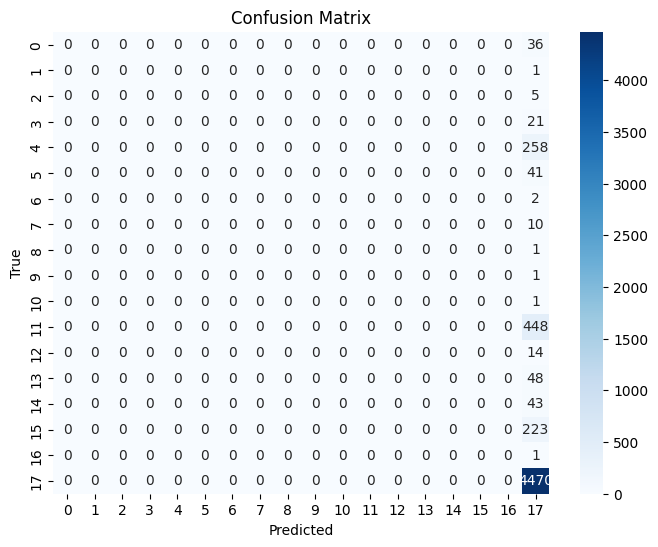

In [24]:
true_labels = np.argmax(ffn.y_test, axis=1)
predicted_labels = np.argmax(ffn.predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
accuracy = Accuracy(task="multiclass", num_classes=51)
y_hat = torch.from_numpy(ffn.predictions)
y_true = torch.from_numpy(ffn.y_test)
float(accuracy(y_hat, y_true))

0.0

## Reproduce evaluation in a new instance of model that receives same weights

In [26]:
ffn2 = tm.models.EstimatorFfn()
ffn2.load_model_full(fn='saved_model')
print(ffn2.evaluate(test_only=True))
ffn2.predict()

RuntimeError: Error(s) in loading state_dict for ModelBiRnn:
	size mismatch for linear_layers.0.weight: copying a param with shape torch.Size([51, 20]) from checkpoint, the shape in current model is torch.Size([51, 22]).